# Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading Glove and Train/Dev data


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!rm glove.6B.50d.txt
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt
!rm glove.6B.zip

--2021-05-01 07:20:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-01 07:20:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-01 07:20:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!git clone https://github.com/SapienzaNLP/nlp2021-hw1
!cp nlp2021-hw1/data/train.jsonl ./
!cp nlp2021-hw1/data/dev.jsonl ./

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
!ls

glove_embeddings = "glove.6B.300d.txt"

train_file = "train.jsonl"
dev_file = "dev.jsonl"

ROOT_FOLDER = 'drive/MyDrive/models/'

dev.jsonl  drive  glove.6B.300d.txt  nlp2021-hw1  sample_data  train.jsonl


In [ ]:
! head -5 {train_file}

{"id": "train.0", "lemma": "play", "pos": "NOUN", "sentence1": "In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.", "sentence2": "A musical play on the same subject was also staged in Kathmandu for three days.", "start1": "69", "end1": "73", "start2": "10", "end2": "14", "label": "False"}
{"id": "train.1", "lemma": "play", "pos": "NOUN", "sentence1": "In that context of coordination and integration, Bolivia holds a key play in any process of infrastructure development.", "sentence2": "In schools, when water is needed, it is girls who are sent to fetch it, taking time away from their studies and play.", "start1": "69", "end1": "73", "start2": "112", "end2": "116", "label": "False"}
{"id": "train.2", "lemma": "esteem", "pos": "NOUN", "sentence1": "We would also like to convey our esteem and congratulations to fraternal Lebanon and its people on the unconditional liberation of its southern part.", "sentence2": "Father L

## Importing libraries

In [ ]:
from torch import FloatTensor as FT
from torch import LongTensor as LT
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter, defaultdict
import numpy as np
import torch
import json
import os
import re
from typing import *
import math
import random
import pickle

from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
SEED = 1111

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
device

'cuda'

# GloVe

We are opening the GloVe embeddings file to load the vector representation of each word.

In [ ]:
lines = []
with open(glove_embeddings) as f:
  lines = f.readlines()

word2vec = {}

word2vec['UNK_TOKEN'] = torch.rand(300, device=device)

for id, line in enumerate(tqdm(lines, position=0, leave=True)):
  line_splitted = line.split(' ')
  word = line_splitted[0]
  word_embedding = torch.tensor([float(x) for x in line_splitted[1:]], 
                                dtype=torch.float32, 
                                device=device)
  word2vec[word] = word_embedding

100%|██████████| 400000/400000 [00:39<00:00, 10178.82it/s]


We are defining a function to save the vocabulary that allow us to export it.

In [ ]:
def save_vocabulary(path: str, name: str):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(word2vec, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_vocabulary(ROOT_FOLDER, 'GloVe-300d')

The following function compute the number of words, unique words, and missing words w.r.t. GloVe embedding both of training set and development set.

In [ ]:
def count_words_dataset(dataset_name: str) -> Tuple[int, int, int]:
    n_words, unique_words, n_missing_words = 0, [], 0
    with open(dataset_name) as f:
        json_list = list(f)
        for json_str in json_list:
            line = json.loads(json_str)
            sentences = line['sentence1'] + ' ' + line['sentence2']
            for w in sentences.split(' '):
                n_words += 1
                if w not in unique_words:
                    unique_words.append(w)
                if w not in word2vec:
                    n_missing_words += 1
    return n_words, len(unique_words), n_missing_words

In [ ]:
n_words_train, n_unique_words_train, n_missing_words_train = count_words_dataset(train_file)
n_words_dev, n_unique_words_dev, n_missing_words_dev = count_words_dataset(dev_file)

print("Train")
print("# words : ", n_words_train)
print("# unique words", n_unique_words_train)
print("# missing words", n_missing_words_train)
print("missing_words / words", round(n_missing_words_train/n_words_train, 3))
print("-"*30)
print("Dev")
print("# words : ", n_words_dev)
print("# unique words", n_unique_words_dev)
print("# missing words", n_missing_words_dev)
print("missing_words / words", round(n_missing_words_dev/n_words_dev, 3))

Train
# words :  385413
# unique words 43068
# missing words 72771
missing_words / words 0.189
------------------------------
Dev
# words :  45595
# unique words 10476
# missing words 8770
missing_words / words 0.192


# Pre-Processing

In this section we are performing the pre-processing step for the sentences. 

In [ ]:
# random string used for highlight the target word and perform pre-processing without care 
# about the change position of the target word 
TARGET_HIGHLIGHTER = 'iardyzywdgjglbwpvmwp'

# adding the highlighter befor the target word
def add_highlighter_target_word(sentence: str, start_target_word: int):
    return sentence[:start_target_word] + TARGET_HIGHLIGHTER + sentence[start_target_word:]

# removing the highlighter 
def remove_highlighter_target_word(sentence: str):
    return sentence.replace(TARGET_HIGHLIGHTER, '')

# removing punctuation and multiple spaces
def remove_punctuation(sentence: str):
    
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(8220), ' ') # “
    sentence = sentence.replace(chr(8212), ' ') # —
    sentence = sentence.replace(chr(8211), ' ') # –
    sentence = sentence.replace(chr(8208), ' ') # ‐
    
    sentence = sentence.replace(chr(8216), '') # ‘
    sentence = sentence.replace(chr(8217), '') # ’
    sentence = sentence.replace(chr(39), '') # '

    for punc in string.punctuation:
        sentence = sentence.replace(punc, ' ')

    sentence = re.sub(' +', ' ', sentence)

    return sentence

# removing stopwords
def remove_stopwords(sentence: str):
    sentence_without_stopwords = ''
    stopWords = set(stopwords.words('english'))
    for word in sentence.split(' '):
        if word not in stopWords:
            sentence_without_stopwords += (word + ' ')
    return sentence_without_stopwords.strip()

# retriving the position of the target word after the preprocessing based on the highlighter
def get_index_target_word(sentence: str):
    i = 1
    for word in sentence.split(' '):
        if word.startswith(TARGET_HIGHLIGHTER):
            return i
        else:
            i += 1

# pre-processing the sentence returning the clean sentence,
# the number of words in the sentence, 
# and the position of the target word
def preprocess_sentence(sentence: str, start_target_word: int):
    sentence = add_highlighter_target_word(sentence, start_target_word)
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = remove_punctuation(sentence)
    sentence = remove_stopwords(sentence)
    index_target_word = get_index_target_word(sentence)
    sentence = remove_highlighter_target_word(sentence)
    n_words = sentence.count(' ')+1
    return sentence, n_words, index_target_word


In [ ]:
s = 'Poodles in Europe tend not to dock the tail of the breed at puppyhood, whereas in North America this is a matter left to the discretion of the owner.'
start = 30

s_p, n_words, target = preprocess_sentence(s, start)

print(s_p, '\n', '#words: ' + str(n_words), '\n', 'target: ' + str(target))

poodles europe tend dock tail breed puppyhood whereas north america matter left discretion owner 
 #words: 14 
 target: 4


# First Approach

In this section we are defining the first approach models.

## sentence2vec

This section implements the aggregation function used for combine the word embeddings of the sentences.

### Mean

The following functions implements the mean aggregation function.

In [ ]:
def sentence2meanvec(sentence: str, target: int) -> Optional[torch.Tensor]:

    # mising words are just ignored
    sentence_word_vector = [word2vec[w] for w in sentence.split(' ') if w in word2vec]

    # stacking the tensors representing each word
    sentence_word_vector = torch.stack(sentence_word_vector)

    # returning the mean component by component of the stacked tensors
    return torch.mean(sentence_word_vector, dim=0)

In [ ]:
def sentence2meanvec_unk(sentence: str, target: int) -> Optional[torch.Tensor]:

    # missing words are represented by a random (fixed) vector
    sentence_word_vector = [word2vec[w] if w in word2vec else word2vec['UNK_TOKEN'] for w in sentence.split(' ')]

    sentence_word_vector = torch.stack(sentence_word_vector)

    return torch.mean(sentence_word_vector, dim=0)

### Sum

The following functions implements the sum aggregation function.

In [ ]:
def sentence2sumvec(sentence: str, target: int) -> Optional[torch.Tensor]:

    # mising words are just ignored
    sentence_word_vector = [word2vec[w] for w in sentence.split(' ') if w in word2vec]

    sentence_word_vector = torch.stack(sentence_word_vector)

    return torch.sum(sentence_word_vector, dim=0)

### Weighted mean

The following function takes in input the length of a sentence and the position of the target word and returns a list of coefficients to be multiplied to each word. The idea behind this function is to follow an exponential distribution to give more importance to words closer to the target word, and less importance to words far from the target word. 

In [ ]:
def get_coefficients(len: int, target: int):

    max_, min_ = max(target, len-target), min(target, len-target)
    
    e = 2

    if target >= len-target:
        a = [e**i for i in range(max_)]
        b = a[-min_-1:-1]
        b.reverse()
    else:
        b = [e**i for i in range(max_+1)]
        b.reverse()
        a = b[1:min_]
        a.reverse()
    
    coefficients = a+b

    coefficients = torch.tensor(coefficients, device=device).float()

    # the coefficients are normalized to sum up to 1
    coefficients = coefficients/torch.sum(coefficients)

    return coefficients

In [ ]:
coefficients = get_coefficients(n_words, target)
coefficients

tensor([4.3493e-02, 8.6986e-02, 1.7397e-01, 3.4794e-01, 1.7397e-01, 8.6986e-02,
        4.3493e-02, 2.1747e-02, 1.0873e-02, 5.4366e-03, 2.7183e-03, 1.3592e-03,
        6.7958e-04, 3.3979e-04], device='cuda:0')

The following functions implements the weighted sum aggregation function.

In [ ]:
def sentence2weightedmeanvec(sentence: str, target: int) -> Optional[torch.Tensor]:

    # mising words are just ignored
    sentence_word_vector = [word2vec[w] for w in sentence.split(' ') if w in word2vec]
    
    n_words = len(sentence_word_vector)

    coefficients = get_coefficients(n_words, target)
    
    sentence_word_vector = torch.stack(sentence_word_vector)

    weighted = torch.stack([sentence_word_vector[i]*coefficients[i] for i in range(n_words-1)])

    return torch.mean(weighted, dim=0)

## Dataset

We are defining the dataset. As soon as the sentences are read from the datasate, they are pre-processed and trasformed in their hidden representation. So, each instance of the following dataset is composed by the concatenation of the hidden representation of the two sentences and the corresponding ground truth.

In [ ]:
class PairsSentencesDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, sentence2vec, min_length: int):
        self.data = []
        self.device = device
        
        self.__init_structures(dataset_path, sentence2vec, min_length)

    def __init_structures(self, dataset_path: str, sentence2vec, min_length: int) -> None:
        
        with open(dataset_path) as f:
        
            json_list = list(f)
        
            for json_str in json_list:
        
                line = json.loads(json_str)

                # retriving information from the provided dataset        
                label = np.float32(0 if line['label'] == 'False' else 1)
                sentence1 = line['sentence1']
                sentence2 = line['sentence2']
                start1, end1 = int(line['start1']), int(line['end1'])
                start2, end2 = int(line['start2']), int(line['end2'])

                # pre-processing the two sentences
                sentence1, n_words1, index_target_word1 = preprocess_sentence(sentence1, start1)
                sentence2, n_words2, index_target_word2 = preprocess_sentence(sentence2, start2)

                # if some problem occurs during the identification of the target word, I ignore that instance
                if index_target_word1 == None or index_target_word2 == None:
                    continue
                if index_target_word1 > n_words1 or index_target_word2 > n_words2:
                    continue
                
                # if one of the pre-processed sentences contains few words, I ignore that instance
                if n_words1 < min_length or n_words2 < min_length:
                    continue

                # computing the hidden representation of the sentences
                sentence_vector1 = sentence2vec(sentence1, index_target_word1)
                sentence_vector2 = sentence2vec(sentence2, index_target_word2)

                # concatenating the hidden representation of the two sentences
                sentences_vector = torch.cat([sentence_vector1, sentence_vector2], dim=0)

                label = torch.tensor(label, device=device)

                self.data.append((sentences_vector, label))

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data[idx]

## Classifier

We are defining the classifier.

In [ ]:
class PairsSentenceClassifier(torch.nn.Module):

    # defining the model architecture
    def __init__(self, n_features: int, dropout: float):
        super().__init__()

        # linear layer
        self.lin1 = torch.nn.Linear(n_features, n_features//2)
        self.lin2 = torch.nn.Linear(n_features//2, 1)
        
        # dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)

        # loss function
        self.loss_fn = torch.nn.BCELoss()


    # defining the forward pass of the model
    def forward(self, X: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        # forward 1st layer
        out = self.lin1(X)
        out = torch.relu(out)

        #dropout regularization
        out = self.dropout(out)
        
        # forward 2nd layer
        out = self.lin2(out)
        
        out = out.squeeze(1)
        out = torch.sigmoid(out)
        
        # storing result
        result = {'pred': out}

        # computing and storing loss
        if y is not None:
          loss = self.loss(out, y)
          result['loss'] = loss 

        # returning result
        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

## Training

We are defining the training loop to train the model. It returns a list containing the accuracies of the model tested on the dev dataset for each epoch.

In [ ]:
def training_loop(model: nn.Module, 
                  optimizer: torch.optim.Optimizer,
                  epochs: int = 50,
                  save: bool = False,
                  _print: bool = False) -> List[float]:
    
    # accuracies list
    accuracies = []

    for epoch in range(epochs):

        # for each batch of the training set
        for X, y in train_dataloader:
            
            # set the gradients to zero before starting backpropragation step
            optimizer.zero_grad()

            # compute the output of the model
            batch_out = model(X, y)

            # retrieve the loss 
            loss = batch_out['loss']

            # compute the gradient of the loss
            loss.backward()

            # update parameters of the model
            optimizer.step()

        # if _print is set to True, it prints the current loss
        if _print:
            print(epoch, loss.item())

        # testing the model
        accuracy = test(model, _print)

        accuracies.append(accuracy)

        # if save is set to True, it saves the current model
        if save:
            torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, ROOT_FOLDER + 'first/1_'+str(epoch)+'.pt')

    # returning the accuracies
    return accuracies

## Test

We are defining the test function to evaluate the model on the dev dataset.

In [ ]:
def test(model: nn.Module, _print: bool = False):    
    
    n = 0
    d = 0

    # for each batch of the test set
    for X, y in dev_dataloader:

        # set the gradients to zero before starting backpropragation step
        with torch.no_grad():

            # predict the batch
            batch_out = model(X)

            # retrieve the predictions
            pred = batch_out['pred']

        # round the sigmoid output to obtain 0/1 values
        pred = torch.round(pred)
        
        # how many predictions, i.e. number of batch items to predict
        d += pred.shape[0]

        # how many correct classifications in the predicted batch
        n += (y == pred).int().sum()

    # computing the accuracy 
    accuracy = round((n / d).item(), 2)
    
    # if _print is set to True, it prints the accuracy
    if _print:
        print(f'# accuracy dev: {accuracy}\n')

    # returning the accuracy
    return accuracy

## Results

### Run model

The following function is used to instantiate the model with the hyper-parameter in input, instantiate the optimizer and run the model. It returns the list of the accuracies.

In [ ]:
def run_model(hparam: Dict, save: bool, _print: bool):

    # instantiating the model
    model = PairsSentenceClassifier(n_features=hparam['n_features'], dropout=hparam['dropout'])

    # instantiating the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hparam['lr'])

    # moving the model to device
    model = model.to(device)

    # getting the accuracies
    accuracies = training_loop(model, optimizer, hparam['n_epochs'], save, _print)

    # returning the accuracies
    return accuracies

### Tests

The following snipped code are used to fix the hyper-parameter of the model and run it, printing the results.

In [ ]:
hparam = {

    'sentence2vec': sentence2meanvec,
    'min_length': 4,
    'batch_size': 32,
    'n_features': 600,
    'dropout': 0.3,
    'lr': 1e-4,
    'n_epochs': 50

}

train_dataset = PairsSentencesDataset(
    train_file, 
    hparam['sentence2vec'],
    hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparam['batch_size'])

dev_dataset = PairsSentencesDataset(
    dev_file, 
     hparam['sentence2vec'],
     hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparam['batch_size'])

accuracies_mean = run_model(hparam, save=True, _print=True)

_max = max(accuracies_mean)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_mean.index(_max))

0 0.6976338624954224
# accuracy dev: 0.57

1 0.6923632621765137
# accuracy dev: 0.59

2 0.6924158334732056
# accuracy dev: 0.59

3 0.6833112239837646
# accuracy dev: 0.6

4 0.6738301515579224
# accuracy dev: 0.61

5 0.6639887094497681
# accuracy dev: 0.62

6 0.6585691571235657
# accuracy dev: 0.62

7 0.6419379115104675
# accuracy dev: 0.63

8 0.6393308639526367
# accuracy dev: 0.61

9 0.6165083050727844
# accuracy dev: 0.63

10 0.6095684170722961
# accuracy dev: 0.64

11 0.5810688734054565
# accuracy dev: 0.64

12 0.6016988158226013
# accuracy dev: 0.64

13 0.5762485265731812
# accuracy dev: 0.64

14 0.5628396272659302
# accuracy dev: 0.65

15 0.5480453968048096
# accuracy dev: 0.64

16 0.5443771481513977
# accuracy dev: 0.66

17 0.5564809441566467
# accuracy dev: 0.65

18 0.4874253571033478
# accuracy dev: 0.64

19 0.5149359107017517
# accuracy dev: 0.65

20 0.4849649667739868
# accuracy dev: 0.64

21 0.4923219084739685
# accuracy dev: 0.65

22 0.47624853253364563
# accuracy dev: 0.65

In [ ]:
hparam = {

    'sentence2vec': sentence2meanvec_unk,
    'min_length': 4,
    'batch_size': 32,
    'n_features': 600,
    'dropout': 0.3,
    'lr': 1e-4,
    'n_epochs': 50

}

train_dataset = PairsSentencesDataset(
    train_file, 
    hparam['sentence2vec'],
    hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparam['batch_size'])

dev_dataset = PairsSentencesDataset(
    dev_file, 
     hparam['sentence2vec'],
     hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparam['batch_size'])

accuracies_mean_unk = run_model(hparam, save=False, _print=False)

_max = max(accuracies_mean_unk)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_mean_unk.index(_max))

Max accuracy:  0.66  - Epoch:  20


In [ ]:
hparam = {

    'sentence2vec': sentence2sumvec,
    'min_length': 4,
    'batch_size': 32,
    'n_features': 600,
    'dropout': 0.3,
    'lr': 1e-4,
    'n_epochs': 50

}

train_dataset = PairsSentencesDataset(
    train_file, 
    hparam['sentence2vec'],
    hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparam['batch_size'])

dev_dataset = PairsSentencesDataset(
    dev_file, 
     hparam['sentence2vec'],
     hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparam['batch_size'])

accuracies_sum = run_model(hparam, save=False, _print=False)

_max = max(accuracies_sum)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_sum.index(_max))

Max accuracy:  0.66  - Epoch:  11


In [ ]:
hparam = {

    'sentence2vec': sentence2weightedmeanvec,
    'min_length': 4,
    'batch_size': 32,
    'n_features': 600,
    'dropout': 0.3,
    'lr': 1e-4,
    'n_epochs': 50

}

train_dataset = PairsSentencesDataset(
    train_file, 
    hparam['sentence2vec'],
    hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparam['batch_size'])

dev_dataset = PairsSentencesDataset(
    dev_file, 
     hparam['sentence2vec'],
     hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparam['batch_size'])

accuracies_wsum = run_model(hparam, save=False, _print=False)

_max = max(accuracies_wsum)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_wsum.index(_max))

Max accuracy:  0.6  - Epoch:  43


### Plot

The following code is used to plot the results of the model with the tested hyper-parameter.

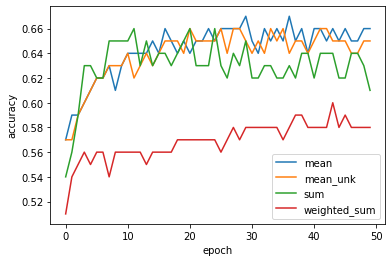

In [ ]:
overall_accuracies_first = [accuracies_mean, accuracies_mean_unk, accuracies_sum, accuracies_wsum]

labels_first = ['mean', 'mean_unk', 'sum', 'weighted_sum']

for accuracies, label in zip(overall_accuracies_first, labels_first):
    plt.plot(accuracies, label=label)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Second Approach

In this section we are defining the second approach models.

## Word vectors

We are defining the vectors of words in order to implement the pytorch embedding layer.

In [ ]:
# dictionary that associate an index to each word
word2idx = {}

# list of vectors in which vector in position i corresponds to word with index i in word2idx
word_vectors = []

# pad token, index = 0
word_vectors.append(torch.zeros(300, device=device))

# unk token, index = 1
word_vectors.append(torch.rand(300, device=device))

for word, vector in word2vec.items():
  word2idx[word] = len(word_vectors)
  word_vectors.append(vector)

word2idx = defaultdict(lambda: 1, word2idx)
word_vectors = torch.stack(word_vectors)
word_vectors = word_vectors.to(device)

## sentence2indices

The following function returns the vector representation fo the input sentence, in which each word is represented by its index in word2idx.

In [ ]:
def sentence2indices(sentence: str) -> torch.Tensor:

    return torch.tensor([word2idx[word] for word in sentence.split(' ')],
                            dtype=torch.long,
                            device=device)

## Dataset

We are defining the dataset. As soon as the sentences are read from the datasate, they are pre-processed and trasformed in their indices representation.
Each instance of the following dataset is composed by the indices representation of the two sentences, the position of the target words in the two sentences and the corresponding ground truth.

In [ ]:
class PairsSentencesRNNDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, min_length: int):
        self.data = []
        self.__init_structures(dataset_path, min_length)

    def __init_structures(self, dataset_path: str, min_length: int) -> None:

        with open(dataset_path) as f:

            json_list = list(f)

            for json_str in json_list:

                line = json.loads(json_str)

                # retriving information from the provided dataset        
                label = np.float32(0 if line['label'] == 'False' else 1)
                sentence1 = line['sentence1'] 
                sentence2 = line['sentence2']
                start1, end1 = int(line['start1']), int(line['end1'])
                start2, end2 = int(line['start2']), int(line['end2'])

                # pre-processing the two sentences
                sentence1, n_words1, index_target_word1 = preprocess_sentence(sentence1, start1)
                sentence2, n_words2, index_target_word2 = preprocess_sentence(sentence2, start2)
                
                # if some problem occurs during the identification of the target word, I ignore that instance
                if index_target_word1 == None or index_target_word2 == None:
                    continue

                # if one of the pre-processed sentences contains few words, I ignore that instance
                if n_words1 < min_length or n_words2 < min_length:
                    continue
                
                # computing the indices representation of the sentences
                sentence_indices1 = sentence2indices(sentence1)
                sentence_indices2 = sentence2indices(sentence2)

                self.data.append(
                    (
                        (sentence_indices1, sentence_indices2),
                        (index_target_word1, index_target_word2),
                        label
                     )
                    )

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, float]:
        return self.data[idx]

## Collate function

The following is the collate function called when we crate the dataloader.

In [ ]:
def rnn_collate_fn(
    data_elements: List[Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[int, int], float]]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    
    X1 = [de[0][0] for de in data_elements]  # list of index tensors of sentences 1
    X2 = [de[0][1] for de in data_elements]  # list of index tensors of sentences 2
    X = X1 + X2 # list of index tensors of all the sentences
  
    # to implement the many-to-one strategy
    X1_lengths = torch.tensor([x1.size(0) for x1 in X1], dtype=torch.long, device=device)
    X2_lengths = torch.tensor([x2.size(0) for x2 in X2], dtype=torch.long, device=device)
    
    # the following tensor is composed by two stacked tensor, 
    # one contains the lengths of the first sentences,
    # the other contains the lengths of the second sentences
    X_lengths = torch.stack([X1_lengths, X2_lengths])
    

    # padding the sentences
    X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)
    X1 = X[:len(X)//2] # retrieving the first sentences
    X2 = X[len(X)//2:] # retrieving the second sentences
    
    # the following tensor is composed by two stacked tensor,
    # one contains the padded first sentences,
    # the other contains the padded second sentences
    X = torch.stack([X1,X2])
    

    indices_target = [de[1] for de in data_elements] #(ind_target1, ind_target2)

    # the following tensor is composed by two stacked tensor,
    # one contains the position of the target word of the first sentences,
    # the other contains the position of the target word of the second sentences
    indices_target = torch.tensor(indices_target, device=device).t()

    # tensor with the ground truth
    y = [de[2] for de in data_elements]
    y = torch.tensor(y, device=device)
    
    return (X, X_lengths, indices_target, y)

In [ ]:
sentence11 = 'the,# Table italia'
sentence12 = 'of. because? yes bolivia day'

sentence21 = 'Here you can find activities to practise your reading skills.'
sentence22 = 'Take our'

sentence11, n_words11,  index_target_word11 = preprocess_sentence(sentence11, 12)
sentence12, n_words12, index_target_word12 = preprocess_sentence(sentence12, 13)
sentence21, n_words21, index_target_word21 = preprocess_sentence(sentence21, 46)
sentence22, n_words22, index_target_word22 = preprocess_sentence(sentence22, 0)


indices11 = sentence2indices(sentence11)
indices12 = sentence2indices(sentence12)

indices21 = sentence2indices(sentence21)
indices22 = sentence2indices(sentence22)

a = [
     ((indices11, indecis12), (index_target_word11, index_target_word12),  1),
     ((indices21, indecis22), (index_target_word21, index_target_word22),  0)
]

X, X_lengths, indices_target, y = rnn_collate_fn(a)

print(X)
print('-'*100)
print(X_lengths)
print('-'*100)
print(indices_target)
print('-'*100)
print(y)
print('-'*100)

tensor([[[ 1804, 14816,     0,     0,     0],
         [  599,  1221, 29062,  2188,  3145]],

        [[ 2775,  6692,   125,     0,     0],
         [  193,     0,     0,     0,     0]]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[2, 5],
        [3, 1]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([[2, 4],
        [1, 1]], device='cuda:0')
----------------------------------------------------------------------------------------------------
tensor([1, 0], device='cuda:0')
----------------------------------------------------------------------------------------------------


## Classifier

We are defining the classifier.

In [ ]:
class PairsSentenceRNNClassifier(torch.nn.Module):

    # defining the model architecture
    def __init__(self, 
                 word_vectors,
                 hidden_size: int,
                 num_layers: int,
                 bias: bool,
                 bidirectional: bool,
                 summary: str,
                 dropout: float):
        
        super().__init__()

        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(word_vectors)

        # hyper-parameter of the LSTM
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional is True else 1
        self.num_layers = num_layers

        self.summary = summary
        
        # LSTM
        self.lstm = torch.nn.LSTM(input_size=word_vectors.size(1), 
                                  hidden_size=hidden_size, 
                                  num_layers=num_layers,
                                  bias=bias,
                                  batch_first=True,
                                  bidirectional=bidirectional)
        
        # classifier, linear layer
        self.lin1 = torch.nn.Linear(self.num_directions*hidden_size*2, hidden_size)
        self.lin2 = torch.nn.Linear(hidden_size, 1)

        # dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)

        # loss
        self.loss_fn = torch.nn.BCELoss()

    # this function returns the output of the LSTM
    def get_summary_lstm(self,
                         X: torch.Tensor,
                         X_indices: torch.Tensor) -> torch.Tensor:

        # X_indices param define which output of the LSTM return

        # tensors of zeros to initialize the LSTM
        h_0 = torch.zeros(self.num_layers*self.num_directions, X.size(0), self.hidden_size, device=device)
        c_0 = torch.zeros(self.num_layers*self.num_directions, X.size(0), self.hidden_size, device=device)

        # computing the embedding
        embedded = self.embedding(X)

        # LSTM output
        out, _ = self.lstm(embedded, (h_0, c_0))

        batch_size, seq_len, _ = out.shape

        # retrieving the output of the LSTM corresponding to the desired token

        summary_word_relative_indices = X_indices - 1

        # sequences offsets in the batch
        sequences_offsets = torch.arange(batch_size, device=device) * seq_len

        # indices corrsponding to the desired token in the batch
        summary_vectors_indices = sequences_offsets + summary_word_relative_indices

        if self.num_directions == 1:

            flattened_out = out.reshape(-1, self.hidden_size)
            summary_vector = flattened_out[summary_vectors_indices]
            summary_vector.squeeze()

        else:

            # separatin forward and backward

            out = out.view(batch_size, seq_len, self.num_directions, self.hidden_size)
            forward = out[:, :, 0, :]
            backward = out[:, :, 1, :]

            # forward summary
            flattened_forward = forward.reshape(-1, self.hidden_size)
            summary_vector_forward = flattened_forward[summary_vectors_indices]
            summary_vector_forward = summary_vector_forward.squeeze()
            
            # backward summary
            flattened_backward = forward.reshape(-1, self.hidden_size)
            summary_vector_backward = flattened_backward[summary_vectors_indices if self.summary == 'target_word' else sequences_offsets]
            summary_vector_backward = summary_vector_backward.squeeze()

            # concatenating forward and backward summary    
            summary_vector = torch.cat([summary_vector_forward, summary_vector_backward], dim=1)

        # returning summary
        return summary_vector

    # defining the forward pass of the model
    def forward(self, 
                X: Tuple[torch.Tensor, torch.Tensor],
                X_length: torch.Tensor,
                X_indices_target: torch.Tensor,
                y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:

        # defining which summary consider
        if self.summary == 'target_word':
            # target word summary
            X_indices = X_indices_target 
        else:
            # last summary for the forward, first summary for the backward
            X_indices = X_length

        # computing the summary for the first and second sentences independently from each other
        summary_vector1 = self.get_summary_lstm(X[0], X_indices[0])
        summary_vector2 = self.get_summary_lstm(X[1], X_indices[1])

        # concatenating the two summary
        summary_vectors = torch.cat([summary_vector1, summary_vector2], dim=1)

        # forward 1st layer
        out = self.lin1(summary_vectors)
        out = torch.relu(out)

        #dropout regularization
        out = self.dropout(out)
        
        # forward 2nd layer
        out = self.lin2(out)
        
        out = out.squeeze(1)
        out = torch.sigmoid(out)
        
        # storing result
        result = {'pred': out}

        # computing and storing loss
        if y is not None:
          loss = self.loss(out, y)
          result['loss'] = loss 

        # returning result
        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

## Training

We are defining the training loop to train the model. It returns a list containing the accuracies of the model tested on the dev dataset for each epoch.

In [ ]:
def training_loop(model: nn.Module, 
                  optimizer: torch.optim.Optimizer,
                  epochs: int = 50,
                  save: bool = False,
                  _print: bool = False) -> List[float]::
    
    # accuracies list
    accuracies = []

    for epoch in range(epochs):

        # for each batch of the training set
        for X, X_lenghts, X_indices_target, y in train_dataloader:
            
            # set the gradients to zero before starting backpropragation step
            optimizer.zero_grad()
            
            # compute the output of the model
            batch_out = model(X, X_lenghts, X_indices_target, y)

            # retrieve the loss 
            loss = batch_out['loss']

            # compute the gradient of the loss
            loss.backward()

            # update parameters of the model
            optimizer.step()

        # if _print is set to True, it prints the current loss
        if _print:
            print(epoch, loss.item())

        # testing the model
        accuracy = test(model, _print)

        accuracies.append(accuracy)

        # if save is set to True, it saves the current model
        if save:
            torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    }, ROOT_FOLDER + 'second/2_'+str(epoch)+'.pt')

    # returning the accuracies
    return accuracies

## Test

In [ ]:
def test(model: nn.Module, _print: bool = False):    

    n = 0
    d = 0

    # for each batch of the test set
    for X, X_lenghts, X_indices_target, y in dev_dataloader:
        
        # set the gradients to zero before starting backpropragation step
        with torch.no_grad():
            
            # predict the batch
            batch_out = model(X, X_lenghts, X_indices_target)
            
            # retrieve the predictions
            pred = batch_out['pred']

        # round the sigmoid output to obtain 0/1 values
        pred = torch.round(pred)
        
        # how many predictions, i.e. number of batch items to predict
        d += pred.shape[0]

        # how many correct classifications in the predicted batch
        n += (y == pred).int().sum()

    # computing the accuracy 
    accuracy = round((n / d).item(), 2)

    # if _print is set to True, it prints the accuracy
    if _print:
        print(f'# accuracy dev: {accuracy}\n')

    # returning the accuracy
    return accuracy

## Results

### Run model

The following function is used to instantiate the model with the hyper-parameter in input, instantiate the optimizer and run the model. It returns the list of the accuracies.

In [ ]:
def run_model_lstm(hparam: Dict, 
                   save: bool = False, 
                   _print: bool = False):

    # instantiating the model
    model = PairsSentenceRNNClassifier(word_vectors=word_vectors,
                                       hidden_size=hparam['hidden_size'],
                                       num_layers=hparam['num_layers'],
                                       bias=hparam['bias'],
                                       bidirectional=hparam['bidirectional'],
                                       summary=hparam['summary'],
                                       dropout=hparam['dropout'])
    
    # instantiating the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

    # moving the model to device
    model = model.to(device)

    # getting the accuracies
    accuracies = training_loop(model, optimizer, hparam['n_epochs'], save, _print)
    
    # returning the accuracies
    return accuracies

###Tests

The following snipped code are used to fix the hyper-parameter of the model and run it, printing the results.

In [ ]:
hparam = {

    'min_length': 4,
    'batch_size': 32,
    'rnn_collate_fn': rnn_collate_fn,
    'hidden_size': 512,
    'num_layers': 1,
    'bias': True,
    'bidirectional': False,
    'summary': 'last_word',
    'dropout': 0.2,
    'lr': 1e-4,
    'n_epochs': 10

}

train_dataset = PairsSentencesRNNDataset(
    train_file, 
    min_length = hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=hparam['batch_size'],
                                               collate_fn=hparam['rnn_collate_fn'])

dev_dataset = PairsSentencesRNNDataset(
    dev_file, 
    min_length = hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset,
                                             batch_size=hparam['batch_size'],
                                             collate_fn=hparam['rnn_collate_fn'])

accuracies_monodir_last = run_model_lstm(hparam, save=False, _print=False)

_max = max(accuracies_monodir_last)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_monodir_last.index(_max))

Max accuracy:  0.64  - Epoch:  3


In [ ]:
hparam = {

    'min_length': 4,
    'batch_size': 32,
    'rnn_collate_fn': rnn_collate_fn,
    'hidden_size': 512,
    'num_layers': 1,
    'bias': False,
    'bidirectional': True,
    'summary': 'last_word',
    'dropout': 0.2,
    'lr': 1e-4,
    'n_epochs': 10

}

train_dataset = PairsSentencesRNNDataset(
    train_file, 
    min_length = hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=hparam['batch_size'],
                                               collate_fn=hparam['rnn_collate_fn'])

dev_dataset = PairsSentencesRNNDataset(
    dev_file, 
    min_length = hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset,
                                             batch_size=hparam['batch_size'],
                                             collate_fn=hparam['rnn_collate_fn'])

accuracies_bidir_last = run_model_lstm(hparam, save=False, _print=False)

_max = max(accuracies_bidir_last)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_bidir_last.index(_max))

Max accuracy:  0.64  - Epoch:  2


In [ ]:
hparam = {

    'min_length': 4,
    'batch_size': 32,
    'rnn_collate_fn': rnn_collate_fn,
    'hidden_size': 512,
    'num_layers': 1,
    'bias': False,
    'bidirectional': True,
    'summary': 'target_word',
    'dropout': 0.2,
    'lr': 1e-4,
    'n_epochs': 10

}

train_dataset = PairsSentencesRNNDataset(
    train_file, 
    min_length = hparam['min_length'])
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=hparam['batch_size'],
                                               collate_fn=hparam['rnn_collate_fn'])

dev_dataset = PairsSentencesRNNDataset(
    dev_file, 
    min_length = hparam['min_length'])
dev_dataloader = torch.utils.data.DataLoader(dataset=dev_dataset,
                                             batch_size=hparam['batch_size'],
                                             collate_fn=hparam['rnn_collate_fn'])

accuracies_bidir_target = run_model_lstm(hparam, save=False, _print=False)

_max = max(accuracies_bidir_target)
print('Max accuracy: ', _max, ' - Epoch: ', accuracies_bidir_target.index(_max))

Max accuracy:  0.55  - Epoch:  0


### Plot

The following code is used to plot the results of the model with the tested hyper-parameter.

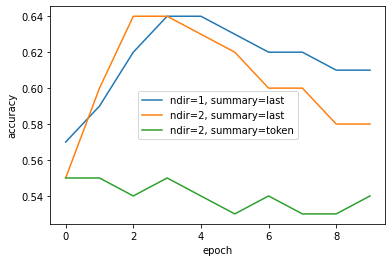

In [ ]:
overall_accuracies_second = [accuracies_monodir_last, accuracies_bidir_last, accuracies_bidir_target]

labels_second = ['ndir=1, summary=last', 'ndir=2, summary=last', 'ndir=2, summary=token']

for accuracies, label in zip(overall_accuracies_second, labels_second):
    plt.plot(accuracies, label=label)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()